### This is a simple time series analysis that apply the seasonal ARIMA (SARIMA) technique by using the monthly beer production dataset.

### Link: [Dataset](https://www.kaggle.com/datasets/sergiomora823/monthly-beer-production)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf

In [2]:
# Load the monthly beer production dataset
df = pd.read_csv("beerproduction.csv", parse_dates = True)

In [3]:
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')

In [4]:
df['Month'] = df['Month'].dt.strftime('%Y-%m') + '-01'

In [5]:
df.set_index('Month', inplace = True)

In [6]:
df.index = pd.to_datetime(df.index)

In [7]:
# View the first few rows of the dataset
df.head()

,Monthly beer production
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


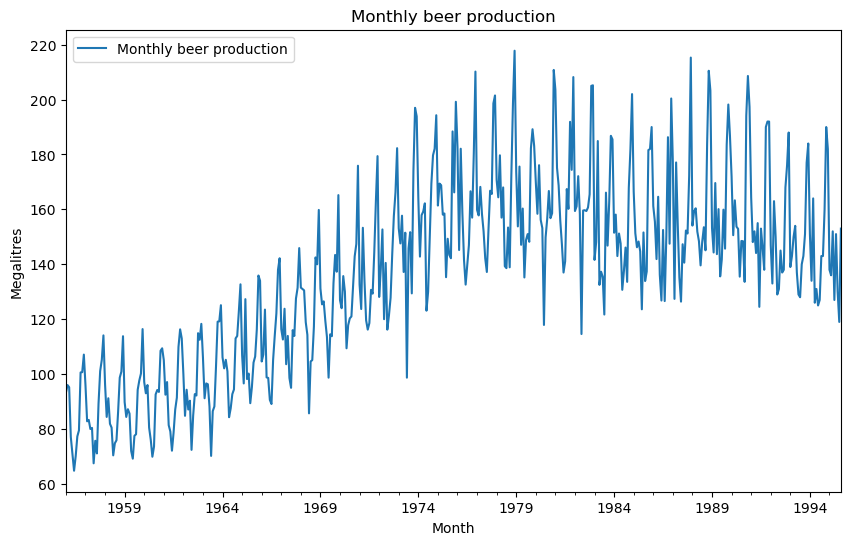

In [8]:
# Visualize the data to determine the trends, seasonality, and stationarity
df.plot(figsize=(10,6))
plt.title("Monthly beer production")
plt.ylabel("Megalitres")
plt.show()

### Based on the plot, we can see that the monthly beer production have seasonal pattern and not stationary

### Next, we check for stationarity by using Augmented Dickey-Fuller Test

In [9]:
# Check for stationarity
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(df["Monthly beer production"])
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

ADF Statistic: -2.2826614187875816
p-value: 0.1776209982913235


### Since the p-value is more than 0.05, we can conclude that the monthly beer production is not stationary.

### To remove the seasonal variation, need to first difference the data.

In [10]:
# Remove the seasonal variation
first_diff = df.diff()[1:]

### After first differencing, the p-value less than 0.05, we can conclude the data is stationary.

In [11]:
adf_test_diff = adfuller(first_diff["Monthly beer production"])
print(f'ADF Statistic: {adf_test_diff[0]}')
print(f'p-value: {adf_test_diff[1]}')

ADF Statistic: -4.9806637430649285
p-value: 2.4234117859945662e-05


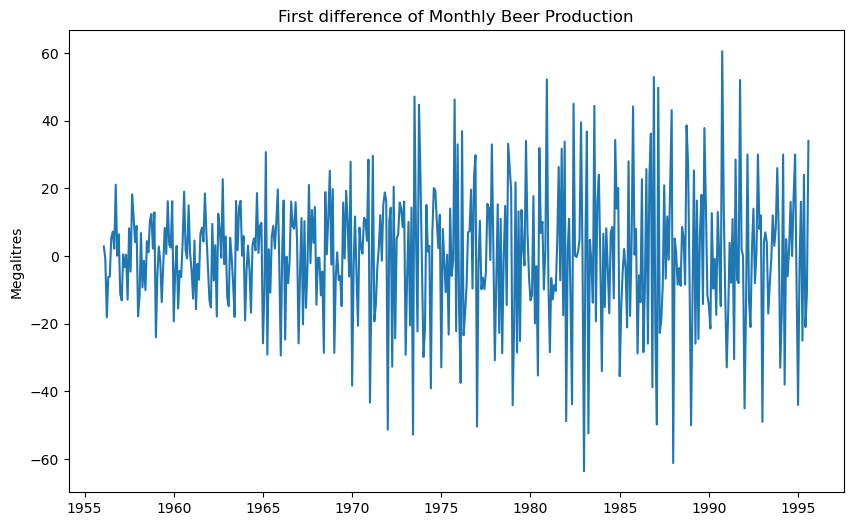

In [12]:
plt.figure(figsize=(10,6))
plt.plot(first_diff)
plt.title("First difference of Monthly Beer Production")
plt.ylabel("Megalitres")
plt.show()

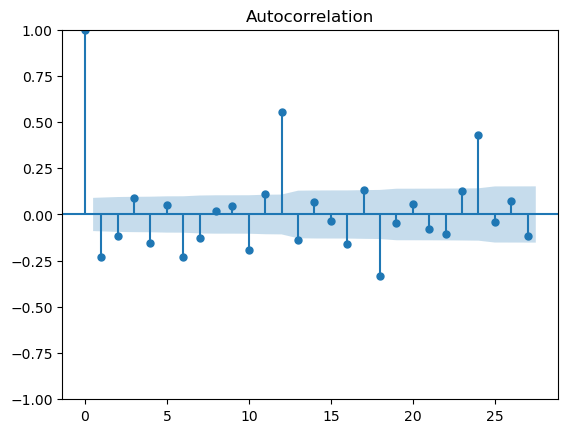

C:\Users\laume\anaconda3\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


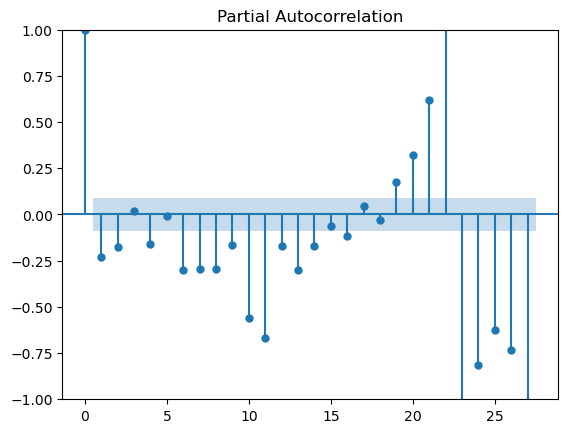

In [13]:
# Plot ACF
plot_acf(first_diff)
plt.show()

# Plot PACF
plot_pacf(first_diff)
plt.show()

### Based on ACF and PACF plot, it suggests that the ARIMA (1,1,1)(1,0,1)12.

### Next, get training and testing sets

In [14]:
# Determine the training and testing sets
train_end = pd.Timestamp("1994-07-01")
test_start = pd.Timestamp("1994-08-01")

train_data = df[df.index < test_start]
test_data = df[df.index >= test_start]

In [15]:
# Fit the SARIMA model
model = SARIMAX(df, order=(1,1,1), seasonal_order=(1,0,1,12))
sarima_fit = model.fit(disp=False)

C:\Users\laume\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\laume\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


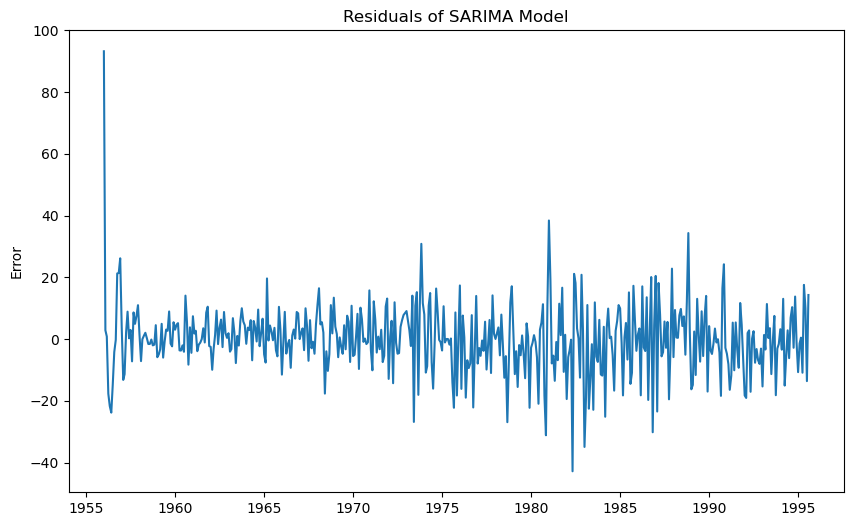

In [16]:
# Calculate the residuals
Residuals = sarima_fit.resid

# Plot the residuals
plt.figure(figsize=(10, 6))
plt.plot(Residuals)
plt.ylabel('Error')
plt.title('Residuals of SARIMA Model')
plt.show()

In [17]:
# summary of the model
print(sarima_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:            Monthly beer production   No. Observations:                  476
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -1784.157
Date:                            Tue, 27 Aug 2024   AIC                           3578.315
Time:                                    23:17:35   BIC                           3599.132
Sample:                                01-01-1956   HQIC                          3586.501
                                     - 08-01-1995                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1525      0.040     -3.847      0.000      -0.230      -0.075
ma.L1         -0.8846      0.021   

In [18]:
# Forecast for the next 12 months of production
forecast = sarima_fit.get_forecast(steps=12)
forecast_index = pd.date_range(start=df.index[-1], periods=13, freq='M')[1:]
forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()
residuals = test_data - forecast_values

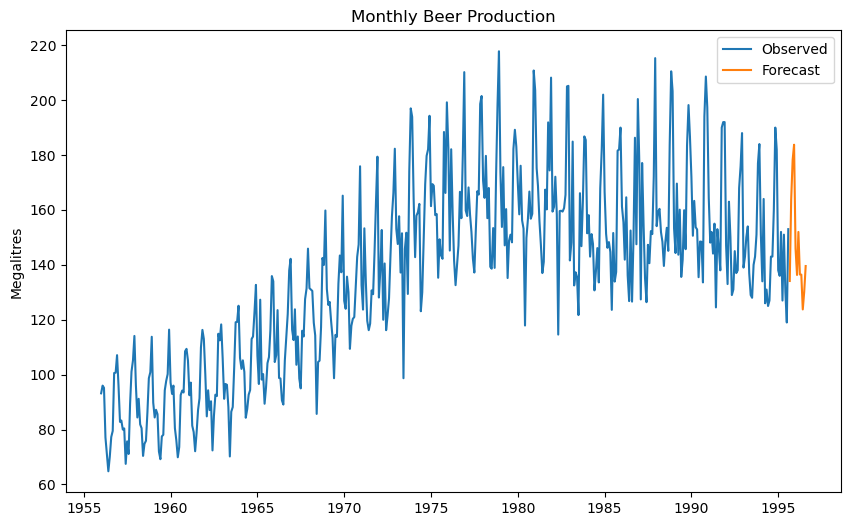

In [19]:
# Plot the forecast along with the observed data
plt.figure(figsize=(10, 6))
plt.plot(df, label='Observed')
plt.plot(forecast_values, label='Forecast')
plt.ylabel("Megalitres")
plt.legend()
plt.title("Monthly Beer Production")
plt.show()

In [20]:
# Evaluate the SARIMA model
in_sample_pred = sarima_fit.get_prediction(start=df.index[0], end=df.index[-1])
in_sample_ci = in_sample_pred.conf_int()

In [21]:
# Calculate the mean squared error
mse = ((in_sample_pred.predicted_mean - df['Monthly beer production']) ** 2).mean()
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 124.62585234488762


In [22]:
# Calculate the root mean squared error
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 11.163594956145964
